<a href="https://colab.research.google.com/github/rahiakela/natural-language-processing-research-and-practice/blob/main/nlp-for-semantic-search/1_dense_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dense Vectors

Reference:

https://www.pinecone.io/learn/dense-vector-embeddings-nlp/

https://www.youtube.com/watch?v=bVZJ_O_-0RE

##Setup

In [1]:
!pip -q install transformers
!pip -q install sentence-transformers

     |████████████████████████████████| 3.4 MB 29.3 MB/s 
     |████████████████████████████████| 3.3 MB 68.0 MB/s 
     |████████████████████████████████| 895 kB 55.7 MB/s 
     |████████████████████████████████| 596 kB 50.6 MB/s 
     |████████████████████████████████| 61 kB 506 kB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 1.2 MB 55.4 MB/s 


In [9]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import CLIPProcessor, CLIPModel

import torch

import requests

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

##Sentence Similarity

Let’s look at how we can quickly pull together some sentence embeddings using the sentence-transformers library.

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")

Then we can go ahead and encode a few sentences, some more similar than others — while sharing very few matching words.

In [ ]:
sentences = [
   "it caught him off guard that space smelled of seared steak",
    "she could not decide between painting her teeth or brushing her nails",
    "he thought there'd be sufficient time is he hid his watch",
    "the bees decided to have a mutiny against their queen",
    "the sign said there was road work ahead so she decided to speed up",
    "on a scale of one to ten, what's your favorite flavor of color?",
    "flying stinging insects rebelled in opposition to the matriarch"          
]

In [ ]:
embeddings = model.encode(sentences)
embeddings.shape

(7, 768)

In [ ]:
embeddings

array([[ 0.07613575,  0.03554152, -0.04853423, ...,  0.02156135,
        -0.02294155, -0.01750991],
       [ 0.02348459,  0.03777696, -0.0244106 , ..., -0.00101797,
         0.01494204, -0.00690051],
       [-0.01087208, -0.06204989, -0.02355074, ...,  0.04565978,
         0.00899556, -0.04353992],
       ...,
       [-0.00952114, -0.00817684, -0.0054946 , ..., -0.01066917,
         0.00550096, -0.01924828],
       [-0.00313652,  0.03131971, -0.00896536, ...,  0.04947064,
        -0.04866311, -0.00352198],
       [ 0.0035543 , -0.04229828,  0.01761915, ...,  0.01523382,
         0.01262348, -0.01886442]], dtype=float32)

In [ ]:
sentences

['it caught him off guard that space smelled of seared steak',
 'she could not decide between painting her teeth or brushing her nails',
 "he thought there'd be sufficient time is he hid his watch",
 'the bees decided to have a mutiny against their queen',
 'the sign said there was road work ahead so she decided to speed up',
 "on a scale of one to ten, what's your favorite flavor of color?",
 'flying stinging insects rebelled in opposition to the matriarch']

In [ ]:
sentences[-1] # get last elemenet

'flying stinging insects rebelled in opposition to the matriarch'

In [ ]:
sentences[:-1] # get all except last elemenet

['it caught him off guard that space smelled of seared steak',
 'she could not decide between painting her teeth or brushing her nails',
 "he thought there'd be sufficient time is he hid his watch",
 'the bees decided to have a mutiny against their queen',
 'the sign said there was road work ahead so she decided to speed up',
 "on a scale of one to ten, what's your favorite flavor of color?"]

And what does our sentence transformer produce from these sentences? A 768-dimensional dense representation of our sentence. The performance of these embeddings when compared using a similarity metric such as cosine similarity is, in most cases — excellent.

In [ ]:
# get cosine of all elemenets with last element
scores = cos_sim(embeddings[-1], embeddings[:-1])

print(sentences[-1])
for i, score in enumerate(scores[0]):
  print(f"{round(score.item(), 4)} | {sentences[i]}")

flying stinging insects rebelled in opposition to the matriarch
0.1232 | it caught him off guard that space smelled of seared steak
0.1967 | she could not decide between painting her teeth or brushing her nails
0.0523 | he thought there'd be sufficient time is he hid his watch
0.6084 | the bees decided to have a mutiny against their queen
0.1011 | the sign said there was road work ahead so she decided to speed up
-0.0492 | on a scale of one to ten, what's your favorite flavor of color?


Despite our most semantically similar sentences about bees and their queen sharing zero descriptive words, our model correctly embeds these sentences in the closest vector space when measured with cosine similarity!

##Question-Answering

First, we initialize tokenizers and models for both our context (ctx) model and question model.

In [ ]:
ctx_model = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

In [ ]:
question_model = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

Given a question and several contexts we tokenize and encode like so:

In [ ]:
questions = [
  "what is the capital city of australia?",
  "what is the best selling sci-fi book?",
  "how many searches are performed on Google?"          
]
contexts = [
  "canberra is the capital city of australia",
  "what is the capital city of australia?",
  "the capital city of france is paris",
  "what is the best selling sci-fi book?",
  "sc-fi is a popular book genre read by millions",
  "the best-selling sci-fi book is dune",
  "how many searches are performed on Google?",
  "Google serves more than 2 trillion queries annually",
  "Google is a popular search engine"
]

In [ ]:
xb_tokens = ctx_tokenizer(contexts, max_length=256, padding="max_length", truncation=True, return_tensors="pt")
xb = ctx_model(**xb_tokens)

In [ ]:
xq_tokens = question_tokenizer(questions, max_length=256, padding="max_length", truncation=True, return_tensors="pt")
xq = question_model(**xq_tokens)

In [ ]:
xb.pooler_output.shape, xq.pooler_output.shape

(torch.Size([9, 768]), torch.Size([3, 768]))

Now we can compare our query embeddings xq against all of our context embeddings xb to see which are the most similar with cosine similarity.

In [ ]:
for i, xq_vec in enumerate(xq.pooler_output):
  probs = cos_sim(xq_vec, xb.pooler_output)
  argmax = torch.argmax(probs)
  print(questions[i])
  print(contexts[argmax])
  print("---")

what is the capital city of australia?
canberra is the capital city of australia
---
what is the best selling sci-fi book?
the best-selling sci-fi book is dune
---
how many searches are performed on Google?
how many searches are performed on Google?
---


Out of our three questions, we returned two correct answers as the very top answer. It’s clear that DPR is not the perfect model, particularly when considering the simple nature of our questions and small dataset for DPR to retrieve from.

##Vision Transformers

Computer vision (CV) has become the stage for some exciting advances from transformer models — which have historically been restricted to NLP.

These advances look to make transformers the first widely adopted ML models that excel in both NLP and CV. And in the same way that we’ve been creating dense vectors representing language. We can do the same for images — and even encode images and text into the same vector space.

<img src='https://d33wubrfki0l68.cloudfront.net/af609dbb57152e5b2e4711f090bb107aa5fbbb67/bffde/images/nlp-embedding-methods-9.jpg?raw=1' width='800'/>

Using specific text and image encoders, we can encode text and images to the same vector space.

The Vision Transformer (ViT) was the first transformer applied to CV without the assistance of any upstream CNNs.

###Image-Text Embedding

Let’s first get a few images to test.

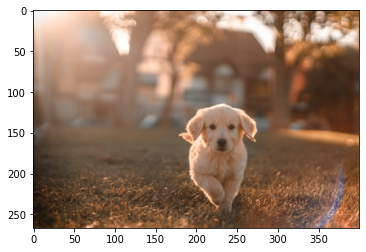

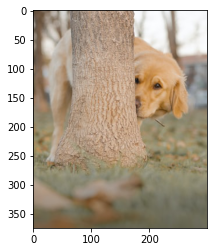

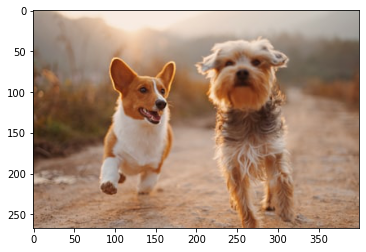

In [8]:
urls = [
  "https://images.unsplash.com/photo-1576201836106-db1758fd1c97?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80",
  "https://images.unsplash.com/photo-1591294100785-81d39c061468?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=300&q=80",
  "https://images.unsplash.com/photo-1548199973-03cce0bbc87b?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80"     
]

images = [Image.open(requests.get(url, stream=True).raw) for url in urls]

# let's see what we have
for image in images:
  plt.show(plt.imshow(np.array(image)))

We can initialize the CLIP model and processor using `transformers` from Hugging Face.

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Now let’s create three true captions (plus some random) to describe our images and preprocess them through our processor before passing them on to our model.

In [11]:
captions = [
  "a dog hiding behind a tree",
  "two dogs running",
  "a dog running",
  "a cucumber on a tree",
  "trees in the park",
  "a cucumber dog"
]

inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)
outputs = model(**inputs)

#  We will get output logits and use an argmax function to get our predictions
probs = outputs.logits_per_image.argmax(dim=1)
probs

tensor([2, 0, 1])

a dog running


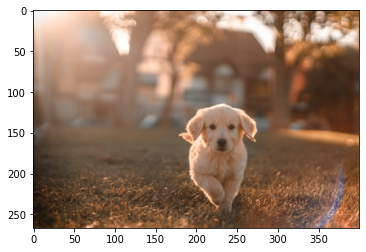

a dog hiding behind a tree


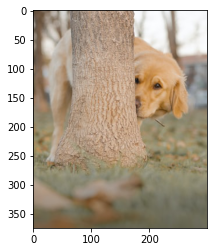

two dogs running


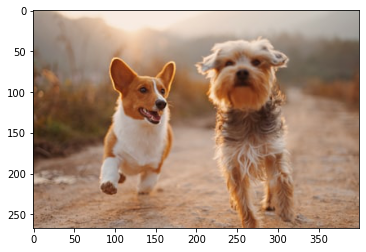

In [12]:
for i, image in enumerate(images):
  argmax = probs[i].item()
  print(captions[argmax])
  plt.show(plt.imshow(np.asarray(image)))

Our model has dealt with comparing text and image embeddings. 

Still, if we wanted to extract those same embeddings used in the comparison, we access `outputs.text_embeds` and `outputs.image_embeds`.

In [13]:
outputs.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

In [14]:
outputs.text_embeds.shape, outputs.image_embeds.shape

(torch.Size([6, 512]), torch.Size([3, 512]))

Let’s compare the embedding for `a dog hiding behind a tree` with our three images with this alternative approach.

In [15]:
xq = outputs.text_embeds[0]  # `a dog hiding behind a tree`
xb = outputs.image_embeds

In [16]:
sim = cos_sim(xq, xb)
sim

tensor([[0.2443, 0.3572, 0.1681]], grad_fn=<MmBackward0>)

In [17]:
preds = sim.argmax().item()
preds

1

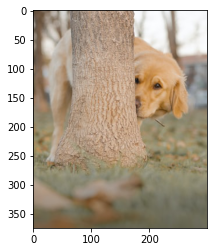

In [18]:
plt.show(plt.imshow(np.asarray(images[preds])))

As expected, we return the dog hiding behind a tree!

That’s it for this overview of both the early days of dense vector embeddings in NLP and the current SOTA. 

We’ve covered some of the most exciting applications of both text and image embeddings, such as:

- Semantic Similarity with `sentence-transformers`
- Q&A retrieval using Facebook AI’s DPR model
- Image-text matching with OpenAI’s CLIP



##References

- [SentenceTransformers Documentation](https://www.sbert.net/index.html)
- [ CLIP Model Card, Hugging Face](https://openai.com/blog/clip/)